# Evaluating Classification Models on Kaggle Titanic Dataset

The data for this project can be found here: https://www.kaggle.com/c/titanic

<b>Background on Data:</b> For each passenger, the titanic data set provided us with: a passenger ID, their socioeconomic status, a passengers age, how many family members they had on board with them, their ticket number, their fare for the voyage, their cabin number, and their port of embarkment. In the training data set, there were 891 unique passengers, and in the test set there were a total of 418 unique passengers.

<b>Overview of Cleanup:</b> Upon review of both the training and the testing data, there were 4 variables which had missing data: age, cabin, fare, and port of embarkment. For age and fare, the missing data was imputed using the mean age and fare respectively. For cabin and port of embarkment, a simple ‘N’ was substituted. Ticket and Name were both variables which were removed from the data. Ticket was removed because there was no clear naming convention for the ticket types. Name was removed as it was a unique identifier, which was unnecessary as we already had a unique id in ‘passengerId’. The log of age was taken since all the values for that variable were non-zero numeric values. Lastly, Cabin, Sex, and Embarked were encoded from from categories to numbers such that a correlation analysis could be conducted. Sex was changed such that males were given a 1, and females were given a 0. P-class was already in a numeric value, but it is worth calling out that a higher value in p-class denoted a lower socio-economic status. 

<b>Results of EDA:</b>  The majority of the EDA was focused on identifying which variables were most correlated with the binary survival rate variable. This is particularly useful for the Cabin variable, as lack of cabin indicates a cheaper ticket and as we will find, a lower chance of survival. This is a case of absence of data being data itself. The cabin variable was transformed into a classifier based on the first letter in the cabin number..  A lack of cabin was given the highest score of 7 whereas all cabin numbers were given lower scores. The result was that fare was correlated with survival, while sex, p-class, and cabin were negatively correlated.

<b>Model performance and Recommendation:</b> Two models were run on this data: a binomial classifier and a logistic regression. They were designed to predict which passengers survived based on the transformed data provided. The models were evaluated for their effectiveness using the area under an ROC curve with 10 fold cross validation. Both models were over 80% effective, with the logistic regression edging out with a .84.(Binomial classifier came in at .82). On Kaggle, both models scored a 0.77033 in effectiveness. The model I would recommend for the historian would depend on his/her stats competency. While logistic regression was marginally more effective, binomial classification is conceptually easier to explain to folks without a stats background.


# Appendix

In [1]:
#Data Frames
import pandas as pd ##DataFrame
import numpy as np ##Numerical Package

#Plots and data prep
import matplotlib as ptl
import matplotlib.pyplot as plt ##Plots
import seaborn as sns ##seaborn visuals
import pandas_profiling
%matplotlib inline
sns.set()

#Scikit Learn
import sklearn as sk ##Scikit learn
import sklearn.linear_model  
from sklearn.model_selection import cross_val_score # Cross validation score
from sklearn.model_selection import train_test_split #train test split
from sklearn.metrics import roc_auc_score as roc
from sklearn.naive_bayes import BernoulliNB as bern
from sklearn.linear_model import LogisticRegression as lr 
from sklearn.model_selection import cross_val_score as cvs
from sklearn import metrics

In [2]:
raw_train = pd.read_csv("C:/Users/stanma02/Desktop/titanic/train.csv")
raw_test = pd.read_csv("C:/Users/stanma02/Desktop/titanic/test.csv")

In [3]:
##show missing values in training
raw_train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [4]:
###breakdown of variables in train data
raw_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [5]:
### Age and Cabin both have a high amount of NAs, while Embark is missing only two variables
##Cabin is a variable where NA means that they did not have a cabin could be replaced
raw_train[raw_train['Embarked'].isnull()]
#raw_train[raw_train['Age'].isnull()]
#raw_train[raw_train['Cabin'].isnull()]


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


In [6]:
##show missing values
raw_test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [7]:
##breakdown of variables in test data
raw_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [8]:
###In the test set, we see the same issues around age and around Cabin
###New issue: we have one passanger where the fare is missing
### all the embarked are here
raw_test[raw_test['Fare'].isnull()]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
152,1044,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S


# EDA

In [9]:
# Make a copy to avoid modifying the original dataset
df = raw_train.copy()
df2 = raw_test.copy()
# Make the Id column as index
df.set_index('PassengerId', inplace=True)
df2.set_index('PassengerId', inplace=True)

In [10]:
# Display only numerical type
num_df = df.select_dtypes('number')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000067409D7348>,
      dtype=object)

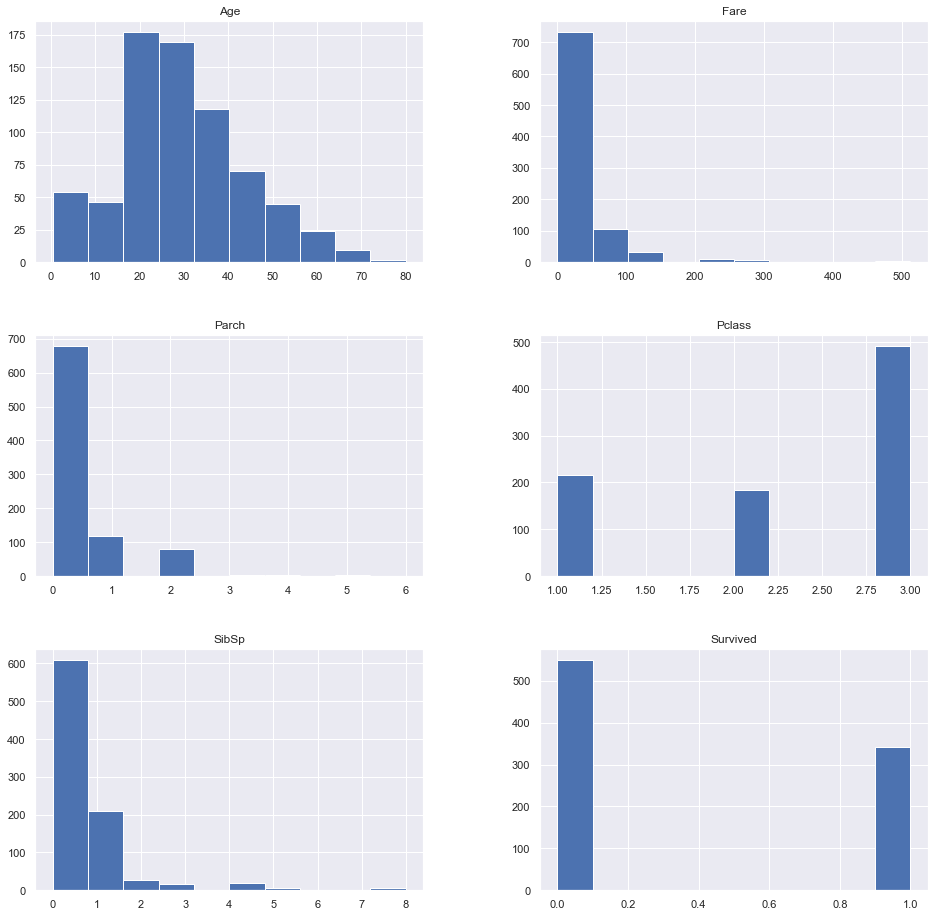

In [11]:
num_df.hist(figsize=(16,16))
##Couple of takeaways here:
## Age could be loged, but for the most part looks fairly normal
##Fares, sibsp and parch have outliers
##Survived and PClass are numbers but are categories

In [12]:
df['Age'].value_counts()
##we have some very small ages but 88 different age values
df['Fare'].value_counts()
##lots of different prices
df['Parch'].value_counts()

0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: Parch, dtype: int64

In [13]:
df['SibSp'].value_counts()

0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64

In [14]:
# Display all non-numerical type
df.select_dtypes('object')

,Name,Sex,Ticket,Cabin,Embarked
PassengerId,,,,,
1,"Braund, Mr. Owen Harris",male,A/5 21171,NaN,S
2,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,PC 17599,C85,C
3,"Heikkinen, Miss. Laina",female,STON/O2. 3101282,NaN,S
4,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,113803,C123,S
5,"Allen, Mr. William Henry",male,373450,NaN,S
...,...,...,...,...,...
887,"Montvila, Rev. Juozas",male,211536,NaN,S
888,"Graham, Miss. Margaret Edith",female,112053,B42,S
889,"Johnston, Miss. Catherine Helen ""Carrie""",female,W./C. 6607,NaN,S


In [15]:
df['Name'].value_counts()
#Name is a unique ID which can be removed
df['Sex'].value_counts()
#Note we have 577 males and 314 females
df['Ticket'].value_counts()
##Note we have 681 unique types of tickets
df['Cabin'].value_counts()
##147 types of cabins doesnt tell us the amount of NA's which are 687
df['Embarked'].value_counts()
##Note we have two NAs

S    644
C    168
Q     77
Name: Embarked, dtype: int64

# Transforming Datasets For EDA

In [16]:
###Initial Correlation Matrix on the Data
corr_matrix = df.corr()
corr_matrix["Survived"].sort_values(ascending=False)

Survived    1.000000
Fare        0.257307
Parch       0.081629
SibSp      -0.035322
Age        -0.077221
Pclass     -0.338481
Name: Survived, dtype: float64

In [17]:
##Handling the missing date in the dataset
df['Age'].fillna(df['Age'].mean(), inplace =True)
df['Cabin'].fillna('N', inplace =True)
df['Embarked'].fillna('N', inplace =True)
df['Fare'].fillna(df['Fare'].mean(), inplace=True)
print('data NUll counts', df.isnull().sum().sum())

data NUll counts 0


In [18]:
#Cabin can be transformed using the letter prefix
df['Cabin'] = df['Cabin'].str[:1]
print(df['Cabin'].head(3))
df['Cabin'].value_counts()

PassengerId
1    N
2    C
3    N
Name: Cabin, dtype: object


N    687
C     59
B     47
D     33
E     32
A     15
F     13
G      4
T      1
Name: Cabin, dtype: int64

In [19]:
####Practice using encoder to transform categories into numbers
from sklearn import preprocessing

def encode_features(data):
    features =['Cabin', 'Sex','Embarked']
    for feature in features:
        le = preprocessing.LabelEncoder()
        le = le.fit(data[feature])
        data[feature] = le.transform(data[feature])
        
    return data

df = encode_features(df)
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,7,3
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,2,0
3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,7,3
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,2,3
5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,7,3


In [20]:
###Correlation Matrix of the key variables
corr_matrix = df.corr()
corr_matrix["Survived"].sort_values(ascending=False)

Survived    1.000000
Fare        0.257307
Parch       0.081629
SibSp      -0.035322
Age        -0.069809
Embarked   -0.174963
Cabin      -0.295113
Pclass     -0.338481
Sex        -0.543351
Name: Survived, dtype: float64

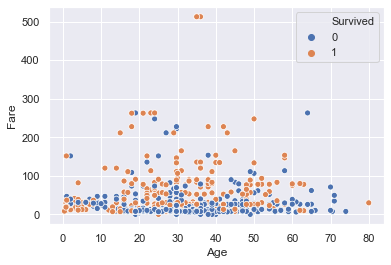

In [21]:
#Scatter between age and Fare with colors for survival or not
sns.scatterplot( x="Age", y="Fare", data=df, hue='Survived', legend="brief")
plt.show()

In [22]:
##Drop Name and Ticket 
df.drop(['Name','Ticket'],axis=1,inplace=True)
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
PassengerId,,,,,,,,,
1,0,3,1,22.0,1,0,7.2500,7,3
2,1,1,0,38.0,1,0,71.2833,2,0
3,1,3,0,26.0,0,0,7.9250,7,3
4,1,1,0,35.0,1,0,53.1000,2,3
5,0,3,1,35.0,0,0,8.0500,7,3


C:\Users\stanma02\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\stanma02\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


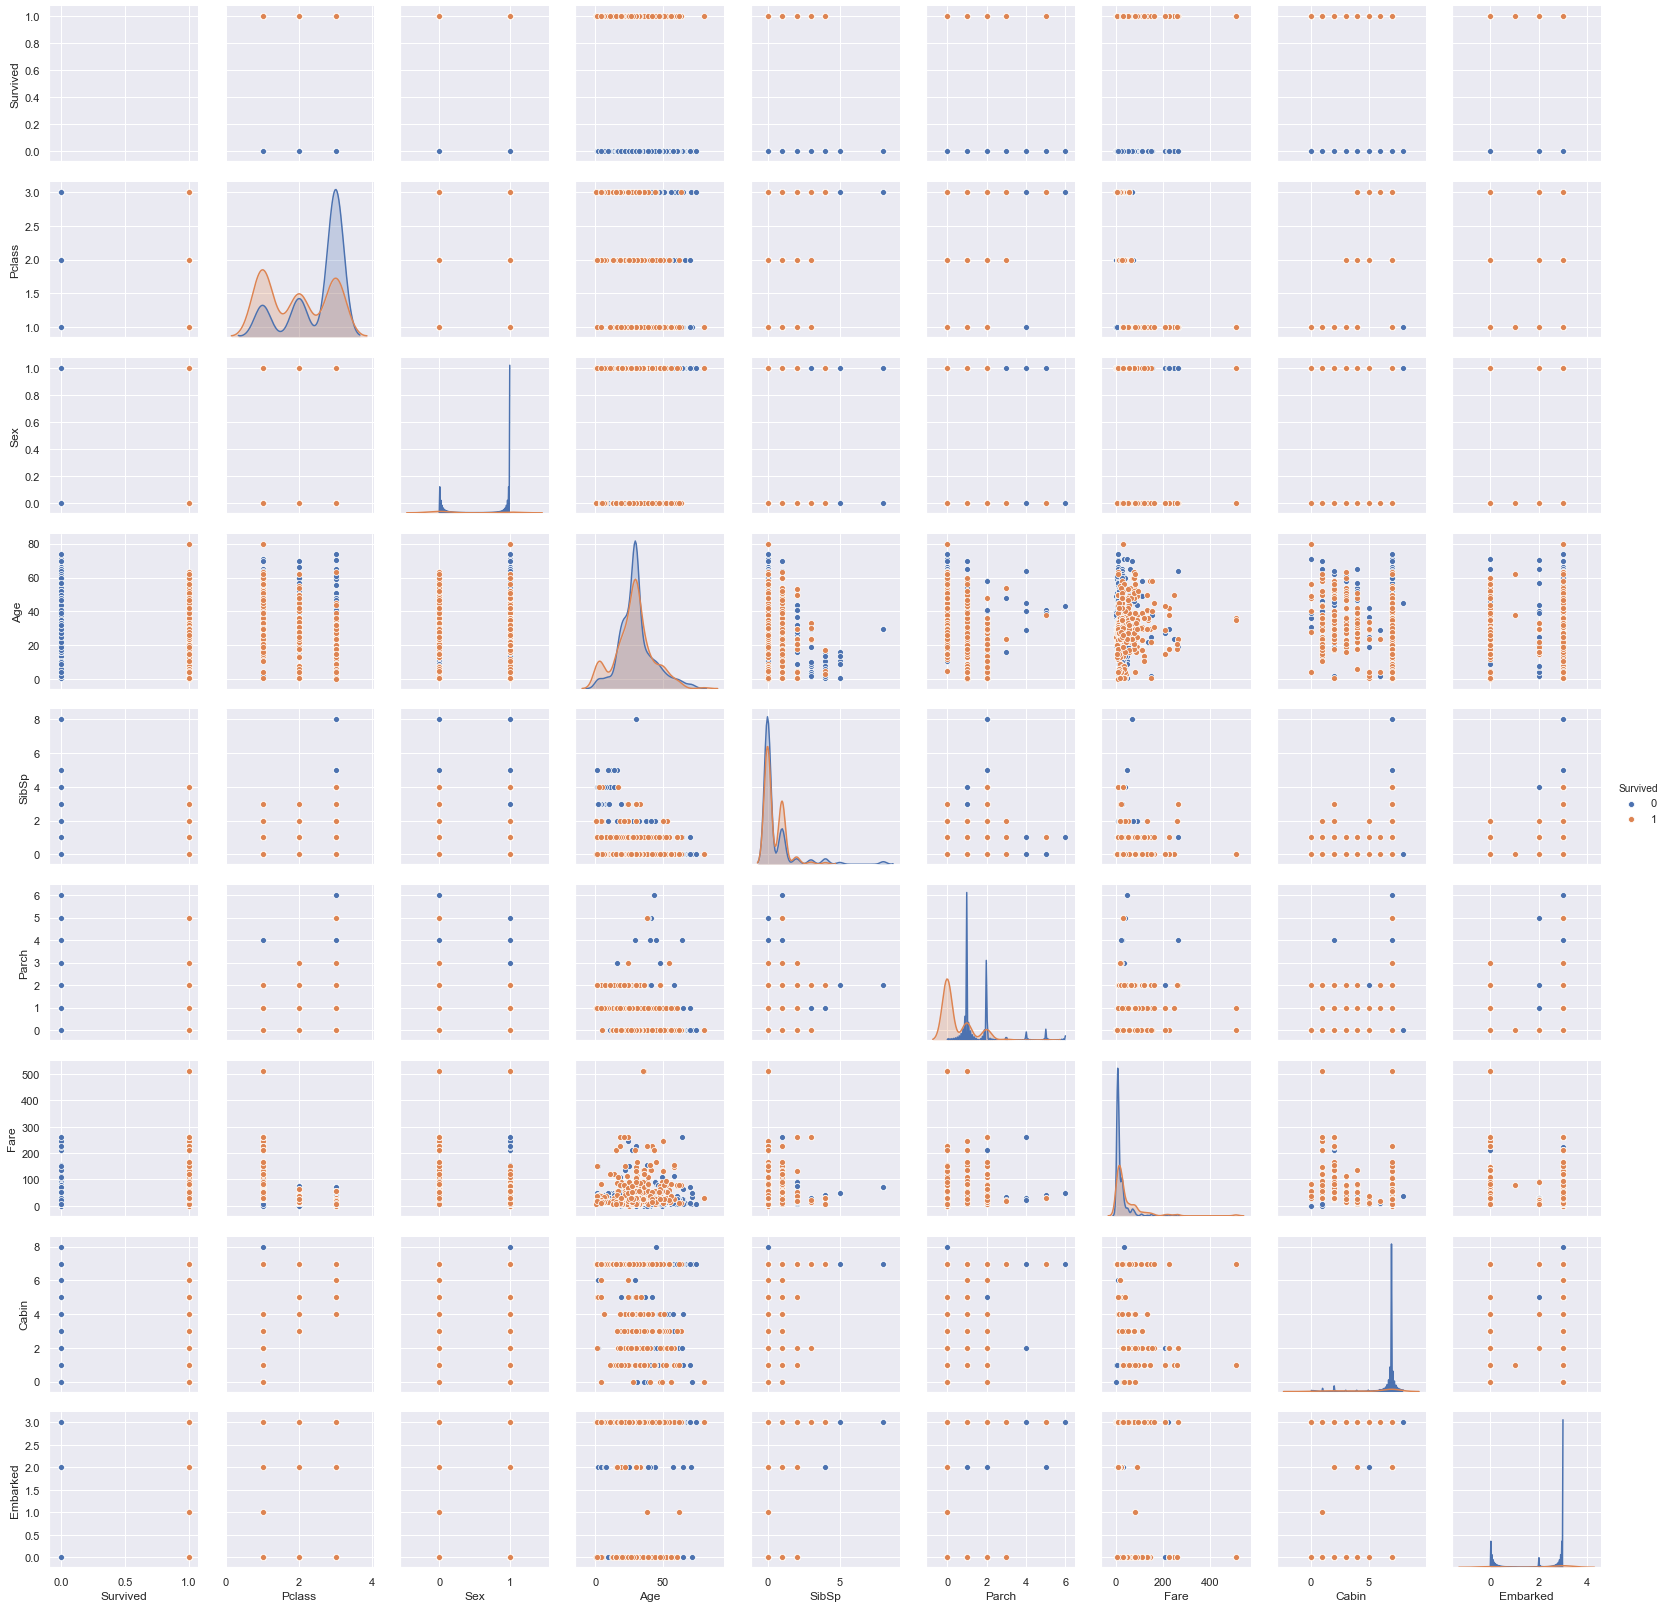

In [23]:
sns.pairplot(df, hue='Survived');

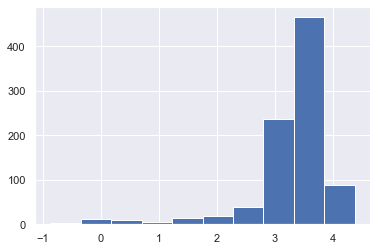

In [24]:
##Log Age since it is a non-negative positive number
np.log(df['Age']).hist()

In [27]:
df['Age']=np.log(df['Age'])
corr_matrix = df.corr()
corr_matrix["Survived"].sort_values(ascending=False)

Survived    1.000000
Fare        0.257307
Parch       0.081629
SibSp      -0.035322
Age        -0.125056
Embarked   -0.174963
Cabin      -0.295113
Pclass     -0.338481
Sex        -0.543351
Name: Survived, dtype: float64

In [28]:
df.shape

(891, 9)

# Custom Transformer

In [67]:
from sklearn import preprocessing

def encode_features(data):
    data['Age'].fillna(data['Age'].mean(), inplace =True)
    data['Age'] = np.log1p(data['Age'])
    data['Fare'].fillna(data['Fare'].mean(), inplace=True)
    data['Cabin'].fillna('N', inplace =True)
    data['Cabin'] = data['Cabin'].str[:1]
    data['Embarked'].fillna('N', inplace =True)
    data.drop(['Name','Ticket'],axis=1,inplace=True)
    
    features =['Cabin', 'Sex','Embarked']
    for feature in features:
        le = preprocessing.LabelEncoder()
        le = le.fit(data[feature])
        data[feature] = le.transform(data[feature])
        
    return data

# Create and Transforming Training Data

In [84]:
# Make a copy to avoid modifying the original dataset
df3 = raw_train.copy()
df4 = raw_test.copy()
# Make the Id column as index
df3.set_index('PassengerId', inplace=True)
df4.set_index('PassengerId', inplace=True)

In [71]:
df3 = encode_features(df3)
df3.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
PassengerId,,,,,,,,,
1,0,3,1,3.135494,1,0,7.2500,7,3
2,1,1,0,3.663562,1,0,71.2833,2,0
3,1,3,0,3.295837,0,0,7.9250,7,3
4,1,1,0,3.583519,1,0,53.1000,2,3
5,0,3,1,3.583519,0,0,8.0500,7,3


In [72]:
### splitting the testing and training data
train_set, test_set = train_test_split(df3, test_size = 0.2, random_state = 1234)

In [75]:
X_train= train_set.drop('Survived', axis = 1)

###Keep the dependent variable separate
y_train = np.array(train_set['Survived'])

X_test= test_set.drop('Survived', axis = 1)

###Keep the dependent variable separate
y_test = np.array(test_set['Survived'])

# check to make sure the dataset looks right
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)  

(712, 8) (712,) (179, 8) (179,)


# Logistic Regression

In [76]:
nfolds=10

clf = lr(solver="lbfgs", multi_class="ovr") ##leave one out CV=8000
mycvs=cvs(clf,X_train,y_train,cv=nfolds)
print("Accuracy of LR: \n", mycvs)

C:\Users\stanma02\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\stanma02\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\stanma02\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\stanma02\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\stanma02\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear

Accuracy of LR: 
 [0.76388889 0.84722222 0.76056338 0.84507042 0.81690141 0.81690141
 0.81690141 0.76056338 0.81690141 0.76056338]


C:\Users\stanma02\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\stanma02\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\stanma02\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


# Naive Bayes


 Accuracy of NB: 
 [0.77777778 0.76388889 0.74647887 0.8028169  0.77464789 0.73239437
 0.81690141 0.73239437 0.8028169  0.81690141]


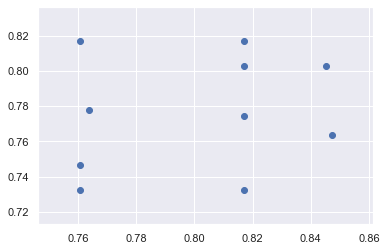

In [77]:
clf1=bern()
mycvs1=cvs(clf1, X_train, y_train, cv=nfolds)
print("\n Accuracy of NB: \n", mycvs1)  #NOTE:  These are going to be close.  Why?


from matplotlib.pyplot import scatter
scatter(mycvs, mycvs1)

# Fit full training data

In [79]:
clf.fit(X_train,y_train)
mypred=clf.predict_proba(X_train)
mypred = [p[1] for p in mypred]
mypredclass=clf.predict(X_train)

clf1.fit(X_train,y_train)
mypred1=clf1.predict_proba(X_train)
mypred1=[p[1] for p in mypred1]
mypredclass1=clf1.predict(X_train)

def metrics(y,mypred):
    print("Area Under the Curve:", roc(y,mypred))
    
metrics(y_train,mypred)
metrics(y_train,mypred1)

Area Under the Curve: 0.8598220254010696
Area Under the Curve: 0.7914146056149732


C:\Users\stanma02\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


# Run testing data

In [80]:
mypred=clf.predict_proba(X_test)
mypred = [p[1] for p in mypred]
mypredclass=clf.predict(X_test)

mypred1=clf1.predict_proba(X_test)
mypred1=[p[1] for p in mypred1]
mypredclass1=clf1.predict(X_test)

metrics(y_test,mypred)
metrics(y_test,mypred1)

Area Under the Curve: 0.8802096985583224
Area Under the Curve: 0.821559633027523


# Graph the ROC curve

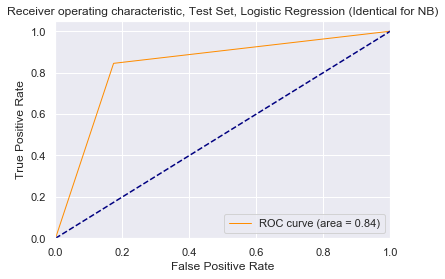

In [81]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(mypredclass, y_test)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic, Test Set, Logistic Regression')
plt.legend(loc="lower right")
plt.show()


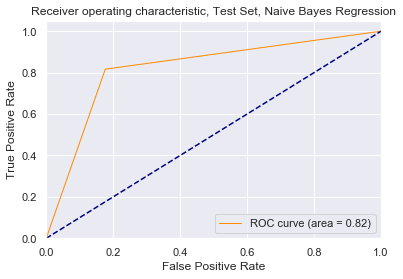

In [98]:
fpr, tpr, thresholds = roc_curve(mypredclass1, y_test)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic, Test Set, Naive Bayes Regression')
plt.legend(loc="lower right")
plt.show()

# Submissions

In [85]:
# Applying Transformations To Kaggle Testing Data
df4 = encode_features(df4)

In [86]:
# Getting predictions for submission Logisitic regression
lg_predictions = clf.predict(df4)

In [88]:
# Getting predictions for submission Naive bayes
Nb_predictions = clf1.predict(df4)

In [94]:
# Packaging submission up for logistic regression
my_solution = pd.DataFrame(lg_predictions,df4.index, columns = ['Survived'])
my_solution.to_csv("submission_1.csv")

In [96]:
# Packaging submission up for Naive bayes
my_solution = pd.DataFrame(Nb_predictions, df4.index, columns = ['Survived'])
my_solution.to_csv("submission_2.csv")